In [1]:
import gzip, json
import logging
import gensim
from glob import glob
from tqdm import tqdm
from os.path import join
from itertools import islice
from os import path
from common import *
from nltk.tokenize import sent_tokenize
from sklearn.metrics.pairwise import cosine_similarity

from gensim.models import Word2Vec
from joblib import Parallel, delayed
import multiprocessing
cpu_count = multiprocessing.cpu_count()

DATA_FOLDER = '../data/'

Using TensorFlow backend.


In [2]:
ziped = sorted(glob(DATA_FOLDER + '/documents/*.gz'), key=natural_keys)
all_docs = get_all_docs(DATA_FOLDER)

In [3]:
with open(join(DATA_FOLDER, 'gold.json'), 'r') as f:
    gold = json.load(f)

In [4]:
val_docs = glob(join(DATA_FOLDER, 'validate/*.txt'))

In [5]:
def extract_first(ziped, n=2):
    for fn in tqdm(ziped):
        with gzip.GzipFile(fn, 'r') as myzip:
            text = myzip.read()
        docs = json.loads(text)
        yield list(get_first(docs, n))

In [6]:
def get_first(docs, n=2):
    for doc in docs:
        first_n = []
        nvalid = 0
        for sentence in doc:
            if nvalid >= n:
                break
            purified = [w for w in sentence if w not in stop_list]
            if len(purified) > 1:
                nvalid += 1
            first_n += purified
        yield list(set(first_n))

In [7]:
def wrap(list_block, n=2):
    return list(extract_first(list_block, n))

In [8]:
sub_data = list(extract_first(ziped[:1], n=1))

100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


In [9]:
len(sub_data)

1

In [10]:
sub_data[0][0]

['реконструкция', 'кольцевой', 'мегаполис', 'магистраль']

In [11]:
all_docs[0]

'../data/FIPS/Inventions patents_txt_output/06/06/0002136803C119990910RU.txt'

In [12]:
with open(all_docs[0], 'r') as f:
    text = f.read()
text

"кольцевой магистраль мегаполис и способ реконструкция кольцевой магистраль мегаполис  . \n изобретение относиться к область строительство , а именно к конструкция кольцевой магистраль крупный город - мегаполис , такой как москва , а также способ реконструкция кольцевой магистраль мегаполис .\n технический результат , обеспечивать изобретение , состоять в оптимизация конструкция , функциональный возможность кольцевой магистраль , а также способ ее реконструкция , обеспечение возможность сокращение трудо- и материалозатрата , а также эксплуатационный затрата , а также срок возведение за счет обеспечение возможность оптимальный выбор потребный количество искусственный сооружение на 1 км магистраль , а также оптимальный подбор состав использовать асфальтобетон , параметр элемент конструкция , режим осуществление отдельный операция и способ реконструкция кольцевой магистраль в целый , а также повышение пропускной способность магистраль и обеспечение оптимальный перераспределение транспортн

In [13]:
parallelizer = Parallel(n_jobs=cpu_count)

# this iterator returns the functions to execute for each task
tasks_iterator = ( delayed(wrap)(list_block, 2) for 
                  list_block in grouper(10, ziped) ) 
result = parallelizer( tasks_iterator )

100%|██████████| 10/10 [00:04<00:00,  1.27it/s]


In [14]:
docs = sum(sum(result, []), [])

In [15]:
len(docs)

1194429

In [16]:
len(all_docs)

1194429

In [15]:
fn = join(DATA_FOLDER, 'first2.json.gz')

In [9]:
with gzip.GzipFile(fn, 'w', compresslevel=1) as fout:
    json_str = json.dumps(docs)
    json_bytes = json_str.encode('utf-8')

    fout.write(json_bytes)

NameError: name 'docs' is not defined

In [16]:
with gzip.GzipFile(fn, 'r') as myzip:
    text = myzip.read()
docs = json.loads(text)
del text

In [17]:
def doc_vec(wv, doc):
    valid_words = [w for w in doc if w in wv]
    if len(valid_words) == 0:
        return np.zeros(wv.syn0.shape[1])
    
    vecs = wv[valid_words]    
    docvec = np.mean(vecs.T , axis=1) # * softmax(scores)

    return docvec

In [18]:
model = Word2Vec.load(join(DATA_FOLDER, 'vectors/w2v_model_300_w10'))
wv = model.wv

In [19]:
train_vecs = []
train_names = []
for i, doc in enumerate(tqdm(docs)):
    docvec = doc_vec(wv, doc)
    name = path.splitext(path.basename(all_docs[i]))[0]
    train_names.append(name)
    train_vecs.append(docvec)

100%|██████████| 1194429/1194429 [02:41<00:00, 7403.53it/s] 


In [20]:
assert len(train_vecs) == len(all_docs)

In [21]:
val_vecs = []
val_names = []
for fname in tqdm(val_docs):
    with open(fname, 'r') as f:
        text = f.read()

    doc = []
    for sent in sent_tokenize(text):
        doc.append(list(tokenize(sent, stop_list)))
    doc = list(get_first([doc]))[0]
        
    docvec = doc_vec(wv, doc)
    name = path.splitext(path.basename(fname))[0]
    val_names.append(name)
    val_vecs.append(docvec)

# test_vecs = pd.DataFrame.from_dict(test_vecs, orient='index')

100%|██████████| 130/130 [00:00<00:00, 139.68it/s]


In [22]:
len(val_vecs)

130

In [23]:
sim_mat = cosine_similarity(val_vecs, train_vecs)

In [27]:
best = {}
for i, vec in enumerate(tqdm(sim_mat)):
    val_name = val_names[i]
    train_ixs = vec.argsort()[-1000:][::-1]
    top_train = [train_names[i] for i in train_ixs]
    best[val_name] = top_train

100%|██████████| 130/130 [00:18<00:00,  6.60it/s]


In [31]:
[fn for fn in all_docs if '0002425930C120110810RU' in fn]

['../data/FIPS/Inventions patents_txt_output/a7/40/0002425930C120110810RU.txt']

In [32]:
all_docs.index('../data/FIPS/Inventions patents_txt_output/a7/40/0002425930C120110810RU.txt')

112518

In [33]:
docs[112518]

['монолитный',
 'железобетонный',
 'безбалочный',
 'каркас',
 'строительство',
 'строительство',
 'здание',
 'монолитный',
 'железобетон']

In [30]:
best['_a5_03_2009140669A10010101RU']

['0002187607C220020820RU',
 '0002425930C120110810RU',
 '0002193638C120021127RU',
 '0000137041U120140127RU',
 '0002247812C220050310RU',
 '0002244076C120050110RU',
 '0002179612C120020220RU',
 '0002519082C220140610RU',
 '0002394140C120100710RU',
 '0002194825C220021220RU',
 '0002283401C120060910RU',
 '0002305159C220070827RU',
 '0002166032C120010427RU',
 '0000140555U120140510RU',
 '0000143970U120140810RU',
 '0002355850C120090520RU',
 '0002392393C120100620RU',
 '0002330146C120080727RU',
 '0002291260C120070110RU',
 '0002341626C120081220RU',
 '0000142157U120140620RU',
 '0002199632C120030227RU',
 '0092008982A19950310RU',
 '0000149222U120141227RU',
 '0002181420C220020420RU',
 '0002382852C120100227RU',
 '0002384675C120100320RU',
 '0002206674C120030620RU',
 '0002453662C120120620RU',
 '0002233368C120040727RU',
 '0094021758A119960210RU',
 '0000143287U120140720RU',
 '0002490403C120130820RU',
 '0000149047U120141220RU',
 '0002362856C120090727RU',
 '0002382154C120100220RU',
 '0002309228C120071027RU',
 '

median
acc10     0.0
acc20     0.0
acc200    0.0
dtype: float64
mean
acc10     0.162821
acc20     0.205128
acc200    0.325641
dtype: float64


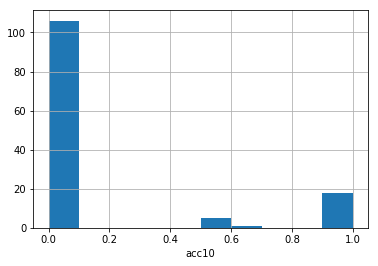

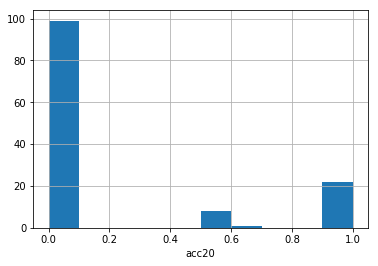

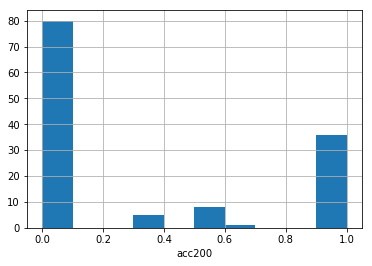

In [25]:
res = evaluate(best, gold)

In [29]:
docs[0]

['конструкция',
 'город',
 'мегаполис',
 'магистраль',
 'крупный',
 'реконструкция',
 'кольцевой',
 'строительство',
 'область',
 'москва']

# Debug

In [72]:
best['_03_43_2008151996A10010101RU']

['2008151996A20100710RU',
 '0000077306U120081020RU',
 '0002126480C119990220RU',
 '0000129946U120130710RU',
 '2002102942A20040310RU',
 '0000069094U120071210RU',
 '0000104209U120110510RU',
 '0000104212U120110510RU',
 '0000119366U120120820RU',
 '0000094580U120100527RU',
 '0002102568C119980120RU',
 '0098110586A20000310RU',
 '0000101455U120110120RU',
 '2011118342A20120127RU',
 '0000087438U120091010RU',
 '2011112603A20121010RU',
 '0000115796U120120510RU',
 '0094045978A119961010RU',
 '0000124690U120130210RU',
 '0000132103U120130910RU',
 '0000019394U120010827RU',
 '2000116464A20020420RU',
 '2007135391A20090327RU',
 '0000010749U119990816RU',
 '0000078839U120081210RU',
 '0097112737A19990320RU',
 '0000104573U120110520RU',
 '0000061306U120070227RU',
 '2007148877A20090710RU',
 '0000135671U120131220RU',
 '0000107208U120110810RU',
 '0000097748U120100920RU',
 '0000043563U120050127RU',
 '2005116375A20061120RU',
 '2006137892A20080510RU',
 '2007123786A20090110RU',
 '0000073893U120080610RU',
 '0000027603U

In [73]:
fn = [fn for fn in val_docs if '_03_43_2008151996A10010101RU' in fn][0]
with open(fn, 'r') as f:
    text = f.read()
text

"\ufeffплоскостной бетонный несущий конструкция и способ ее изготовление .\n железобетонный перекрытие , отличаться совокупность следующий признак : - бетонный плита (1 ) , толщина ( d ) который маленький общий толщина железобетонный перекрытие ; - перекрещивать ребро (2 ) , который один конец (3 ) соединять с возможность передача усилие с бетонный плита (1 ) и свободно отстоять вверх от бетонный плита (1 ) , т . е . без связь с другой несущий плоскостной конструкция , причем они верхний конец (4 ) выполнять с возможность восприятие сжимать и / или растягивать усилие , причем ребро (2 ) соединять между себя в точка (9 ) пересечение с силовой замыкание ; - они участок , лежать между верхний и нижний конец (3 , 4 ) , иметь , по меньший мера , один проем (6 ) . .\n 1 .\n железобетонный перекрытие , отличать тем , что иметься :- бетонный плита (1 ) , толщина ( d ) который маленький общий толщина бетонный несущий конструкция ;- перекрещивать ребро (2 ) , который один конец (3 ) соединять с 

In [75]:
gold['_03_43_2008151996A10010101RU'][0]

'0000033590U120031027RU'

In [76]:
fn = [fn for fn in all_docs if gold['_03_43_2008151996A10010101RU'][0] in fn][0]
with open(fn, 'r') as f:
    text = f.read()
text

'строительный панель и сборный здание из панель  . \n 1 .\n панель здание , содержать каркас в вид ребро и элемент жесткость , наружный и внутренний обшивка , отличать тем , что ребро и элемент жесткость выполнять из металлический труба квадратный сечение , на элемент жесткость прикреплять швеллерообразный скобка , в который располагать и закреплять бруск на длина поперечный элемент жесткость , в свой очередь на бруск прикреплять в продольный направление доска на расстояние друг от друг , на который крепиться внутренний обшивка , а наружный обшивка крепиться к ребро жесткость .\n 2 .\n сборный здание , состоять из соединенный между себя рядовой панель , панель с дверный проем , панель с оконный проем , панель перекрытие и пол , фронтонный панель , отличать тем , что , по крайний мера , панель стена содержать каркас из ребро и элемент жесткость , который выполнять из металлический труба квадратный сечение , на элемент жесткость прикреплять швеллерообразный скобка , в который располагать

In [78]:
fn = [fn for fn in all_docs if '0000077306U120081020RU' in fn][0]
with open(fn, 'r') as f:
    text = f.read()
text

'аэродромный многослойный покрытие  . \n 1 .\n аэродромный многослойный покрытие , включать внутренний несущий и наружный облицовочный слой с располагать между они теплоизоляционный слой , соединенный между себя анкерный болт , отличать тем , что в качество внутренний несущий слой использовать железобетонный плита с анкерный болт , укладывать на песчаный основание и располагать относительно друг друг с зазор так , чтобы расстояние между крайний анкерный болт два соседний железобетонный плита быть равно сторона термостойка металлобетонный плита , в образовать зазор последовательно укладывать щебень на половина высота железобетонный плита , арматура и бетонный смесь , затем на лицевой поверхность железобетонный плита и затвердевать бетонный смесь укладывать теплоизоляционный слой и между выступать анкерный болт термостойкий металлобетонный плита , жестко соединенный между себя , выполнять роль наружный облицовочный слой .\n 2 .\n аэродромный многослойный покрытие по п.1 , отличать тем , 